In [77]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet

In [107]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
        else:
            thetaarray[j] = theta
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create form matrix
def find_form(fixtures_list):
    
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    mat_form = np.zeros((N, 2))
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        mat_form[i, 0] = form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht]
        mat_form[i, 1] = form[team_count[ind_for_season_at].astype(int), ind_for_season_at]
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    
    return(teams_for_season, mat_form)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

### Optimization of players

#### Probability functions of points scoring

In [79]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(lambda_2, mins_played):
    return(int(mins_played > 60) * sample_clean_sheet_for_team(lambda_2))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [132]:
def ComputeExpectedPoints(fixtures_list, form, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250, additionalstats=False):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))
    clean_sheets = np.zeros((Niter, len(all_players_params.index)))
    goals_scored = np.zeros((Niter, len(all_players_params.index)))
    mplayed = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):

        # sample lambdas for team performance - sample from team hyperparameters
        lambdas = predict_fixtures(fixtures_list, form, teams, mu, a, d, alpha, uncertainty=True)

        for i in range(len(all_players_params.index)):  # sample performance of teams from poisson model, and players also 
            h_games = np.where(fixtures_list[:, 0] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            a_games = np.where(fixtures_list[:, 1] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            if (len(h_games) > 0 or len(a_games) > 0):  # players in championship wont get any points this season!
                if all_players_params.loc[all_players_params.index[i], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                for k in range(len(h_games)):  # over all home games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[0][h_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    csp = sample_clean_sheet_points(lambdas[1][h_games[k]], mins_played)
                    points[l, i] += ((scaling[2] * csp) +
                                           (sample_mins_points(mins_played)))
                    clean_sheets[l, i] += csp
                    goals_scored[l, i] += goa
                    mplayed[l, i] += mins_played
                for k in range(len(a_games)):  # over all away games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[1][a_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    csp = sample_clean_sheet_points(lambdas[0][a_games[k]], mins_played)
                    points[l, i] += ((scaling[2] * csp) +
                                           (sample_mins_points(mins_played)))
                    clean_sheets[l, i] += csp
                    goals_scored[l, i] += goa
                    mplayed[l, i] += mins_played

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)
    cs = np.mean(clean_sheets, axis=0)
    gs = np.mean(goals_scored, axis=0)
    mp = np.mean(mplayed, axis=0)

    if additionalstats:
        return(expected_points, sd_points, cs, gs, mp)
    else:
        return(expected_points, sd_points)

### Historical fitting

In [81]:
form = np.ones((380, 2)) * 7.5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [84]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("../data/team_id_20192020.csv", header=0)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [86]:
C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_this_season, form, teams, all_players_params, all_teams_params, Niter=500,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


---
Realisation  0
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
316                 Andrew Robertson
329                  Raheem Sterling
310                    Mohamed Salah
Name: player, dtype: object  with  [158. 159. 159. 169. 228.]  points
---
Realisation  1
Top Points Scorers:  311                     Roberto Firmino
763    Ricardo Domingos Barbosa Pereira
316                    Andrew Robertson
315                     Virgil van Dijk
310                       Mohamed Salah
Name: player, dtype: object  with  [159. 163. 164. 173. 208.]  points
---
Realisation  2
Top Points Scorers:  128    César Azpilicueta
130        Marcos Alonso
828         Matt Doherty
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [164. 171. 175. 183. 209.]  points
---
Realisation  3
Top Points Scorers:  828        Matt Doherty
220    Gylfi Sigurdsson
310       Mohamed Salah
840        Raúl Jiménez
130       Marcos Alonso


---
Realisation  33
Top Points Scorers:  310        Mohamed Salah
329      Raheem Sterling
339        Sergio Agüero
828         Matt Doherty
516    Christian Eriksen
Name: player, dtype: object  with  [161. 167. 172. 176. 177.]  points
---
Realisation  34
Top Points Scorers:  128            César Azpilicueta
329              Raheem Sterling
322    Ederson Santana de Moraes
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [164. 172. 173. 190. 228.]  points
---
Realisation  35
Top Points Scorers:  128            César Azpilicueta
322    Ederson Santana de Moraes
341                  Kyle Walker
721                  Lucas Digne
310                Mohamed Salah
Name: player, dtype: object  with  [161. 162. 169. 184. 212.]  points
---
Realisation  36
Top Points Scorers:  316     Andrew Robertson
516    Christian Eriksen
130        Marcos Alonso
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [156. 156. 

---
Realisation  66
Top Points Scorers:  66                    Lewis Dunk
322    Ederson Santana de Moraes
329              Raheem Sterling
310                Mohamed Salah
128            César Azpilicueta
Name: player, dtype: object  with  [165. 165. 167. 169. 173.]  points
---
Realisation  67
Top Points Scorers:  315      Virgil van Dijk
169        Wilfried Zaha
316     Andrew Robertson
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [165. 168. 171. 181. 193.]  points
---
Realisation  68
Top Points Scorers:  315      Virgil van Dijk
329      Raheem Sterling
306           Sadio Mané
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [157. 157. 186. 191. 193.]  points
---
Realisation  69
Top Points Scorers:  130                Marcos Alonso
826                   Willy Boly
310                Mohamed Salah
772        Alisson Ramses Becker
322    Ederson Santana de Moraes
Name: player, dtype: object  with  [160. 161. 

---
Realisation  101
Top Points Scorers:  134          Eden Hazard
310        Mohamed Salah
721          Lucas Digne
128    César Azpilicueta
329      Raheem Sterling
Name: player, dtype: object  with  [163. 169. 172. 175. 184.]  points
---
Realisation  102
Top Points Scorers:  306         Sadio Mané
134        Eden Hazard
52         Ryan Fraser
315    Virgil van Dijk
310      Mohamed Salah
Name: player, dtype: object  with  [165. 168. 170. 184. 231.]  points
---
Realisation  103
Top Points Scorers:  276        Jamie Vardy
329    Raheem Sterling
306         Sadio Mané
828       Matt Doherty
310      Mohamed Salah
Name: player, dtype: object  with  [167. 168. 171. 193. 221.]  points
---
Realisation  104
Top Points Scorers:  830        Ryan Bennett
828        Matt Doherty
175    Luka Milivojevic
826          Willy Boly
310       Mohamed Salah
Name: player, dtype: object  with  [166. 177. 190. 209. 224.]  points
---
Realisation  105
Top Points Scorers:  43                    Nathan Aké
29

---
Realisation  134
Top Points Scorers:  67          Shane Duffy
828        Matt Doherty
134         Eden Hazard
175    Luka Milivojevic
310       Mohamed Salah
Name: player, dtype: object  with  [162. 163. 166. 173. 213.]  points
---
Realisation  135
Top Points Scorers:  175         Luka Milivojevic
772    Alisson Ramses Becker
306               Sadio Mané
315          Virgil van Dijk
310            Mohamed Salah
Name: player, dtype: object  with  [166. 166. 168. 173. 233.]  points
---
Realisation  136
Top Points Scorers:  276                  Jamie Vardy
134                  Eden Hazard
828                 Matt Doherty
322    Ederson Santana de Moraes
130                Marcos Alonso
Name: player, dtype: object  with  [165. 172. 172. 172. 186.]  points
---
Realisation  137
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
220                    Gylfi Sigurdsson
329                     Raheem Sterling
516                   Christian Eriksen
310                       Mohame

In [87]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)

In [88]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [89]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,200.946667,28.315788,144.315092,257.578242
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,165.273333,23.752866,117.767602,212.779064
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,156.006667,17.277537,121.451592,190.561741
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,154.780000,17.455799,119.868401,189.691599
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,152.380000,20.227925,111.924151,192.835849
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,150.780000,20.657160,109.465680,192.094320
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,146.533333,14.511451,117.510430,175.556236
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,146.526667,23.271641,99.983384,193.069949
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,143.446667,21.015403,101.415861,185.477472
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,60.5,3,Virgil van Dijk,DEF,Liverpool,143.306667,17.201917,108.902832,177.710501


In [90]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,146.533333,14.511451,117.510430,175.556236
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,140.700000,12.926845,114.846309,166.553691
710,710,19.5,1.0,1665.0,1.5,1.0,21.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,129.226667,13.530778,102.165110,156.288223
775,775,20.0,1.0,1755.0,1.0,1.0,22.0,82.5,3,David de Gea,GKP,Man United,125.520000,12.398774,100.722452,150.317548
196,196,32.2,1.0,2781.0,0.2,1.0,34.2,90.7,3,Jordan Pickford,GKP,Everton,122.280000,12.277416,97.725169,146.834831
506,506,28.3,1.0,2502.0,4.1,1.0,30.3,99.1,3,Hugo Lloris,GKP,Tottenham,121.953333,14.513597,92.926140,150.980527
844,844,19.5,1.0,1710.0,1.5,1.0,21.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,117.340000,12.717353,91.905294,142.774706
474,474,31.7,1.0,2781.0,0.7,1.0,33.7,85.1,3,Lukasz Fabianski,GKP,West Ham,111.626667,10.465529,90.695609,132.557724
578,578,31.4,1.0,2754.0,1.0,1.0,33.4,85.4,3,Ben Foster,GKP,Watford,110.573333,12.533340,85.506652,135.640014
259,259,30.2,1.0,2644.5,2.2,1.0,32.2,87.8,3,Kasper Schmeichel,GKP,Leicester,109.726667,11.946490,85.833687,133.619647


In [91]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,156.006667,17.277537,121.451592,190.561741
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,154.780000,17.455799,119.868401,189.691599
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,146.526667,23.271641,99.983384,193.069949
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,60.5,3,Virgil van Dijk,DEF,Liverpool,143.306667,17.201917,108.902832,177.710501
316,316,26.4,1.3,2235.0,6.0,8.5,28.4,53.9,3,Andrew Robertson,DEF,Liverpool,139.753333,18.908882,101.935569,177.571098
341,341,27.9,1.5,2268.2,4.5,3.3,29.9,70.2,3,Kyle Walker,DEF,Man City,137.533333,16.258195,105.016944,170.049722
721,721,19.0,3.0,1527.0,2.0,3.5,21.0,26.0,3,Lucas Digne,DEF,Everton,136.893333,17.795935,101.301464,172.485203
826,826,19.5,3.0,1629.0,1.5,1.0,21.5,25.5,3,Willy Boly,DEF,Wolves,136.280000,20.302092,95.675816,176.884184
763,763,18.5,2.0,1606.5,2.5,5.0,20.5,22.5,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,131.206667,19.570487,92.065693,170.347640
833,833,20.0,1.0,1755.0,1.0,1.0,22.0,28.0,3,Conor Coady,DEF,Wolves,127.893333,13.528807,100.835719,154.950948


In [92]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,200.946667,28.315788,144.315092,257.578242
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,165.273333,23.752866,117.767602,212.779064
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,152.380000,20.227925,111.924151,192.835849
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,150.780000,20.657160,109.465680,192.094320
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,143.446667,21.015403,101.415861,185.477472
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,138.673333,19.716828,99.239678,178.106988
372,372,27.4,9.3,2192.0,5.0,9.9,29.4,31.0,3,Paul Pogba,MID,Man United,131.633333,19.305756,93.021821,170.244846
220,220,28.1,8.7,2283.1,4.3,5.2,30.1,24.6,3,Gylfi Sigurdsson,MID,Everton,128.940000,17.273189,94.393622,163.486378
563,563,29.9,9.0,2221.1,2.5,4.9,31.9,26.2,3,Richarlison de Andrade,MID,Everton,128.233333,17.914023,92.405287,164.061379
817,817,19.5,5.5,1567.5,1.5,4.0,21.5,18.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,122.700000,16.240998,90.218005,155.181995


In [93]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,20.7,3,Jamie Vardy,FWD,Leicester,137.266667,17.390674,102.485318,172.048015
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,26.4,3,Harry Kane,FWD,Tottenham,134.680000,21.067928,92.544144,176.815856
840,840,20.0,7.5,1601.0,1.0,6.0,22.0,12.5,3,Raúl Jiménez,FWD,Wolves,131.560000,15.554412,100.451176,162.668824
339,339,25.0,17.8,1861.5,7.4,8.3,27.0,37.3,3,Sergio Agüero,FWD,Man City,125.253333,20.588730,84.075872,166.430794
169,169,27.2,8.7,2328.2,5.2,8.6,29.2,18.4,3,Wilfried Zaha,FWD,Crystal Palace,125.113333,18.843756,87.425821,162.800846
311,311,29.6,11.5,2176.0,2.8,7.4,31.6,47.5,3,Roberto Firmino,FWD,Liverpool,116.680000,14.887274,86.905452,146.454548
592,592,28.3,8.6,2175.0,4.1,5.9,30.3,16.1,3,Salomón Rondón,FWD,Newcastle,112.880000,15.077542,82.724916,143.035084
31,31,22.9,15.0,1722.8,9.5,5.7,24.9,21.9,3,Pierre-Emerick Aubameyang,FWD,Arsenal,112.206667,22.945819,66.315028,158.098305
22,22,28.9,11.7,1952.6,3.5,8.5,30.9,32.3,3,Alexandre Lacazette,FWD,Arsenal,110.653333,15.868622,78.916090,142.390577
396,396,31.1,9.4,2248.8,1.3,3.8,33.1,21.7,3,Ayoze Pérez,FWD,Newcastle,107.066667,12.959767,81.147133,132.986200


### Analysis of previous season - model verification

In [133]:
# create fixture list this season to predict
fixture_list_last_season = pd.read_csv("../data/prem_results_20182019.csv", header=None).as_matrix()

teams_this_season, form = find_form(fixture_list_last_season)

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_last_season, form, teams, all_players_params, all_teams_params, Niter=100,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed i

---
Realisation  0
Top Points Scorers:  721        Lucas Digne
315    Virgil van Dijk
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [170. 173. 176. 235. 235.]  points
---
Realisation  1
Top Points Scorers:  31     Pierre-Emerick Aubameyang
306                   Sadio Mané
128            César Azpilicueta
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [168. 183. 184. 197. 229.]  points
---
Realisation  2
Top Points Scorers:  306         Sadio Mané
828       Matt Doherty
276        Jamie Vardy
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [175. 182. 182. 198. 234.]  points
---
Realisation  3
Top Points Scorers:  175    Luka Milivojevic
316    Andrew Robertson
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [171. 180. 181. 191. 232.]  points
---
Realisation  4
Top Points Scorers:  322  

---
Realisation  35
Top Points Scorers:  828              Matt Doherty
299    Trent Alexander-Arnold
516         Christian Eriksen
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [168. 174. 177. 195. 245.]  points
---
Realisation  36
Top Points Scorers:  31     Pierre-Emerick Aubameyang
372                   Paul Pogba
329              Raheem Sterling
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [179. 181. 194. 215. 232.]  points
---
Realisation  37
Top Points Scorers:  329    Raheem Sterling
315    Virgil van Dijk
522         Harry Kane
130      Marcos Alonso
310      Mohamed Salah
Name: player, dtype: object  with  [174. 175. 176. 202. 227.]  points
---
Realisation  38
Top Points Scorers:  516            Christian Eriksen
128            César Azpilicueta
31     Pierre-Emerick Aubameyang
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  wi

---
Realisation  69
Top Points Scorers:  341                  Kyle Walker
322    Ederson Santana de Moraes
516            Christian Eriksen
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [173. 175. 183. 223. 235.]  points
---
Realisation  70
Top Points Scorers:  299    Trent Alexander-Arnold
134               Eden Hazard
840              Raúl Jiménez
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [177. 180. 181. 183. 218.]  points
---
Realisation  71
Top Points Scorers:  721         Lucas Digne
315     Virgil van Dijk
175    Luka Milivojevic
306          Sadio Mané
134         Eden Hazard
Name: player, dtype: object  with  [170. 171. 183. 197. 213.]  points
---
Realisation  72
Top Points Scorers:  721        Lucas Digne
522         Harry Kane
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [173. 173. 176. 218. 245.]  points
---
Re

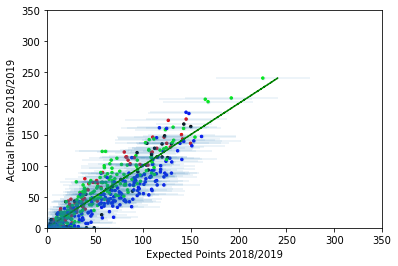

In [167]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
cr = np.zeros((len(y3.index), 3))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = C[ind]
    sd_points[i] = S[ind]
    cr[i, :] = np.array([((all_players_params.loc[all_players_params.index[ind], 'position'] == 'FWD')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'MID')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'DEF'))])

plot.errorbar(exp_points, y3['total_points'] - y3['bonus'], xerr=2 * sd_points, marker='.', linestyle="", alpha=0.1)
plot.scatter(exp_points, y3['total_points'] - y3['bonus'], color=cr, s=6)
plot.plot(y3['total_points'] - y3['bonus'], y3['total_points'] - y3['bonus'], linestyle="--", color='g')
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2018/2019')
plot.ylabel('Actual Points 2018/2019')
plot.show()

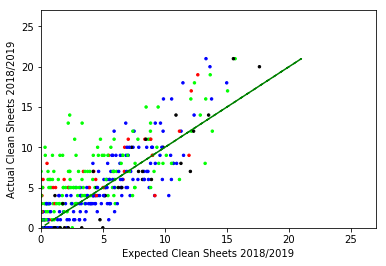

In [168]:
# plot with respect to last seasons clean sheets - for eligble players
clean_sheets = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    clean_sheets[i] = CS[ind]

plot.scatter(clean_sheets, y3['clean_sheets'], color=cr, s=6)
plot.plot(y3['clean_sheets'], y3['clean_sheets'], linestyle="--", color='g')
plot.xlim([0, 27])
plot.ylim([0, 27])
plot.xlabel('Expected Clean Sheets 2018/2019')
plot.ylabel('Actual Clean Sheets 2018/2019')
plot.show()

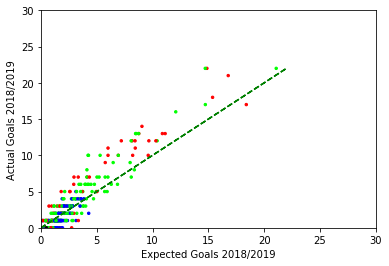

In [171]:
# plot with respect to last seasons goals - for eligble players
goals = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    goals[i] = G[ind]

plot.scatter(goals, y3['goals_scored'], color=cr, s=6)
plot.plot(y3['goals_scored'], y3['goals_scored'], linestyle="--", color='g')
plot.xlim([0, 30])
plot.ylim([0, 30])
plot.xlabel('Expected Goals 2018/2019')
plot.ylabel('Actual Goals 2018/2019')
plot.show()

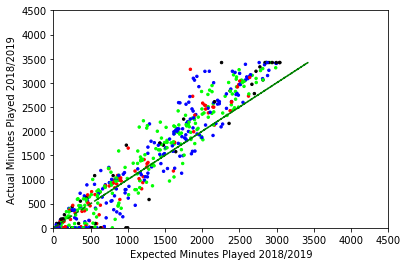

In [172]:
# plot with respect to last seasons mins played - for eligble players
mins_played = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    mins_played[i] = MP[ind]

plot.scatter(mins_played, y3['minutes'], s=6, color=cr)
plot.plot(y3['minutes'], y3['minutes'], linestyle="--", color='g')
plot.xlim([0, 4500])
plot.ylim([0, 4500])
plot.xlabel('Expected Minutes Played 2018/2019')
plot.ylabel('Actual Minutes Played 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, form, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))